In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import csv

In [3]:
try:
    # Read the CSV and skip bad lines
    raw_df = pd.read_csv("Suicide_Detection.csv", on_bad_lines='skip')
    print(raw_df.shape)
except Exception as e:
    print(f"An error occurred: {e}")

(232074, 3)


In [4]:
raw_df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [5]:
raw_df.dtypes

Unnamed: 0     int64
text          object
class         object
dtype: object

In [6]:
df = raw_df.drop("Unnamed: 0", axis=1)
labelencoder = LabelEncoder()
df['class'] = labelencoder.fit_transform(df['class'])

In [7]:
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...
232069,If you don't like rock then your not going to ...,0
232070,You how you can tell i have so many friends an...,0
232071,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,The usual stuff you find hereI'm not posting t...,1


In [8]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [9]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sunio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [11]:
# Preprocess the text data
df['text'] = df['text'].apply(preprocess_text)

# Feature Extraction
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Assuming you have a labeled dataset (0 for non-suicide, 1 for suicide)
y = df['class']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluation
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     23287
           1       0.93      0.91      0.92     23128

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [12]:
import pickle
# Save the model to disk using pickle
with open('suicide_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the vectorizer as well
with open('suicide_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


In [13]:
# After training the model...
feature_names = vectorizer.get_feature_names_out()
# Get the coefficients of the model
coefficients = model.coef_[0]
# Sort them in descending order and get the indices
sorted_indices = coefficients.argsort()[::-1]

print("Top indicators of depression based on model coefficients:")
for i in range(10):  # Let's look at the top 10 indicators
    # Feature names are the words, and coefficients are their corresponding weights
    print(f"{feature_names[sorted_indices[i]]}: {coefficients[sorted_indices[i]]}")


Top indicators of depression based on model coefficients:
suicide: 12.58061503149819
suicidal: 11.51691078453422
kill: 9.039636566026246
killing: 6.963092819642461
pill: 6.025798490385522
die: 5.872276304102521
ending: 5.361554332754518
end: 5.186448824155387
alive: 5.06513072328604
life: 4.9359017858258865


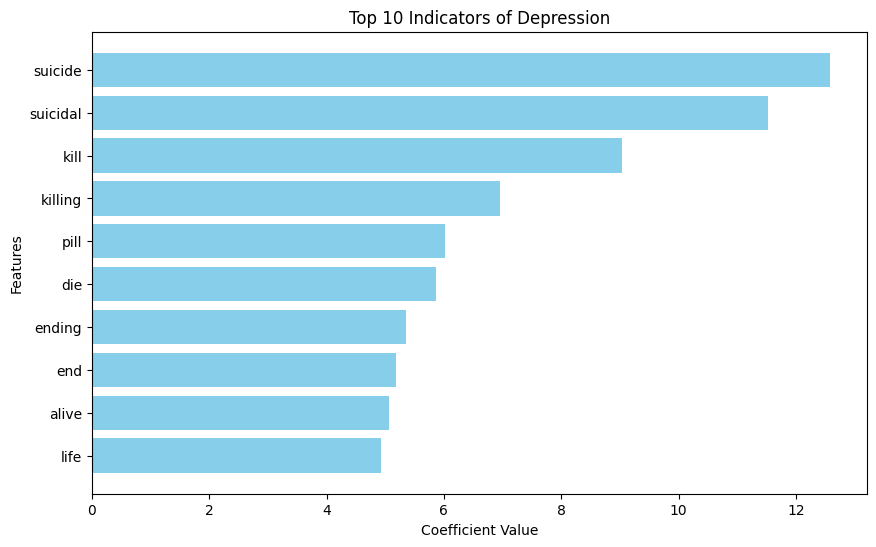

In [33]:
import matplotlib.pyplot as plt

# Assuming 'feature_names' and 'coefficients' are already defined as in your code snippet

# Getting the top 10 features and their coefficients
top_features = [feature_names[i] for i in sorted_indices[:10]]
top_coefficients = [coefficients[i] for i in sorted_indices[:10]]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Top 10 Indicators of Depression')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()


In [50]:
import plotly.express as px
import pandas as pd

# Assuming 'feature_names', 'coefficients', and 'sorted_indices' are already defined as in your code snippet

# Getting the top 10 features and their coefficients
top_features = [feature_names[i] for i in sorted_indices[:10]]
top_coefficients = [coefficients[i] for i in sorted_indices[:10]]

# Create a DataFrame for Plotly
df_plot = pd.DataFrame({
    'Indicator': top_features,
    'Coefficient': top_coefficients,
})

custom_color_scale = ['blue', 'red']
# Create a bar chart using Plotly
fig = px.bar(df_plot, x='Indicator', y='Coefficient', orientation='v', 
             title='Top 10 Indicators of Depression',
             color='Coefficient', color_continuous_scale=custom_color_scale)

# Show the plot
fig.show()


In [36]:
model.predict(vectorizer.transform(["I am very happy"]))

array([0])